In [1]:
import os  # Importing the os module to access environment variables
import requests  # Importing requests to make HTTP requests to the Census API
import pandas as pd  # Importing pandas for data manipulation and analysis
import matplotlib.pyplot as plt  # Importing matplotlib for data visualization
from sklearn.linear_model import LinearRegression  # Importing LinearRegression for prediction modeling
import numpy as np  # Importing numpy for numerical operations

In [2]:
# Retrieve the census API key from the environment variables
# Logic for the API keys
CENSUS_API_KEY = os.getenv("CENSUS_API_KEY")

# Function to retrieve census data for a given year and state
def get_population_data(year, api_key):
    # Format the base URL with the given year
    url = BASE_URL.format(year=year)
    
    # Set up parameters for the API request
    params = {
        "get": f"{MALE_VAR},{FEMALE_VAR}",  # Request male and female population variables
        "for": "us:*",  # Request national data for the entire U.S.
        "key": api_key  # Include the API key for authentication
    }
    
    # Make a GET request to the Census API
    response = requests.get(url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        return response.json()  # Return the JSON data if successful
    else:
        # Raise an exception with the error status code if the request failed
        raise Exception(f"Error fetching data for {year}: {response.status_code}")

# Define the base URL for the Census API
BASE_URL = "https://api.census.gov/data/{year}/acs/acs5"

# Variables for male and female populations in the Census API
MALE_VAR = "B01001_002E"  # Variable for male population
FEMALE_VAR = "B01001_026E"  # Variable for female population

In [3]:
# Initialize lists to store the years and populations
years = []  # List to store years
male_female_ratios = []  # List to store male-to-female ratios
male_female_percentages = []  # List to store male-to-female percentages
male_populations = []  # List to store male population values
female_populations = []  # List to store female population values

# Loop through the last 10 years (2013 to 2022)
for year in range(2013, 2023):
    data = get_population_data(year, CENSUS_API_KEY)  # Retrieve population data for the current year
    
    # Process the data to extract population values
    if data and len(data) > 1 and data[1][0].isdigit() and data[1][1].isdigit():
        # Check if the data is valid and if population values are digits
        male_population = int(data[1][0])  # Convert the male population value to int
        female_population = int(data[1][1])  # Convert the female population value to int
    else:
        # Set male and female populations to 0 if data is invalid
        male_population = 0  
        female_population = 0  
    
    # Calculate male-to-female ratio and percentage
    if female_population > 0:  # Ensure female population is not zero to avoid division by zero
        ratio = male_population / female_population  # Calculate the male-to-female ratio
        percentage = ratio * 100  # Convert ratio to percentage
    else:
        ratio = 0  # Set ratio to 0 if female population is zero
        percentage = 0  # Set percentage to 0 if female population is zero
    
    # Store the year, populations, and percentages in their respective lists
    years.append(year)  # Append the year to the years list
    male_female_ratios.append(ratio)  # Append the calculated ratio to the ratios list
    male_female_percentages.append(percentage)  # Append the calculated percentage to the percentages list
    male_populations.append(male_population)  # Append male population to the male populations list
    female_populations.append(female_population)  # Append female population to the female populations list

In [4]:
# Prepare for future population predictions using Linear Regression
years_array = np.array(years).reshape(-1, 1)  # Reshape the years list to fit the model
future_years = list(range(2023, 2028))  # Define the next 5 years for prediction

# Linear regression model for predicting male population
model_male = LinearRegression()  # Create a LinearRegression model instance
model_male.fit(years_array, male_populations)  # Fit the model with historical male population data
predicted_male_pop = model_male.predict(np.array(future_years).reshape(-1, 1))  # Predict future male populations

# Linear regression model for predicting female population
model_female = LinearRegression()  # Create a LinearRegression model instance
model_female.fit(years_array, female_populations)  # Fit the model with historical female population data
predicted_female_pop = model_female.predict(np.array(future_years).reshape(-1, 1))  # Predict future female populations

# Calculate future male-to-female ratios and percentages
predicted_ratios = [m / f if f != 0 else 0 for m, f in zip(predicted_male_pop, predicted_female_pop)]  # Calculate ratios
predicted_percentages = [r * 100 for r in predicted_ratios]  # Convert ratios to percentages

In [5]:
# Convert the historical data into a pandas DataFrame for easier plotting
df_historical = pd.DataFrame({
    "Year": years,  # Assign the years list to a DataFrame column
    "Male_to_Female_Percentage": male_female_percentages,  # Assign the percentage list to a DataFrame column
    "Male_Population": male_populations,  # Assign the male population list to a DataFrame column
    "Female_Population": female_populations  # Assign the female population list to a DataFrame column
})

print(df_historical)

# Convert the predicted populations to whole numbers
predicted_male_pop = predicted_male_pop.astype(int)  # Convert male predictions to integers
predicted_female_pop = predicted_female_pop.astype(int)  # Convert female predictions to integers

# Convert the future prediction data into a pandas DataFrame
df_future = pd.DataFrame({
    "Year": future_years,  # Assign future years to a DataFrame column
    "Male_to_Female_Percentage": predicted_percentages,  # Assign predicted percentages to a DataFrame column
    "Male_Population": predicted_male_pop,  # Assign predicted male populations to a DataFrame column
    "Female_Population": predicted_female_pop  # Assign predicted female populations to a DataFrame column
})

print("\n df_future:")
print(df_future)

   Year  Male_to_Female_Percentage  Male_Population  Female_Population
0  2013                  96.814836        153247412          158289182
1  2014                  96.818908        154515159          159591925
2  2015                  96.861278        155734280          160780741
3  2016                  96.892620        156765322          161792840
4  2017                  96.952553        158018753          162985654
5  2018                  96.989577        158984190          163918840
6  2019                  97.012359        159886919          164810876
7  2020                  97.024299        160818530          165750778
8  2021                  98.010885        163206615          166518866
9  2022                  98.384038        164200298          166897295

 df_future:
   Year  Male_to_Female_Percentage  Male_Population  Female_Population
0  2023                  97.952248        165043335          168493669
1  2024                  98.086934        166226170          169

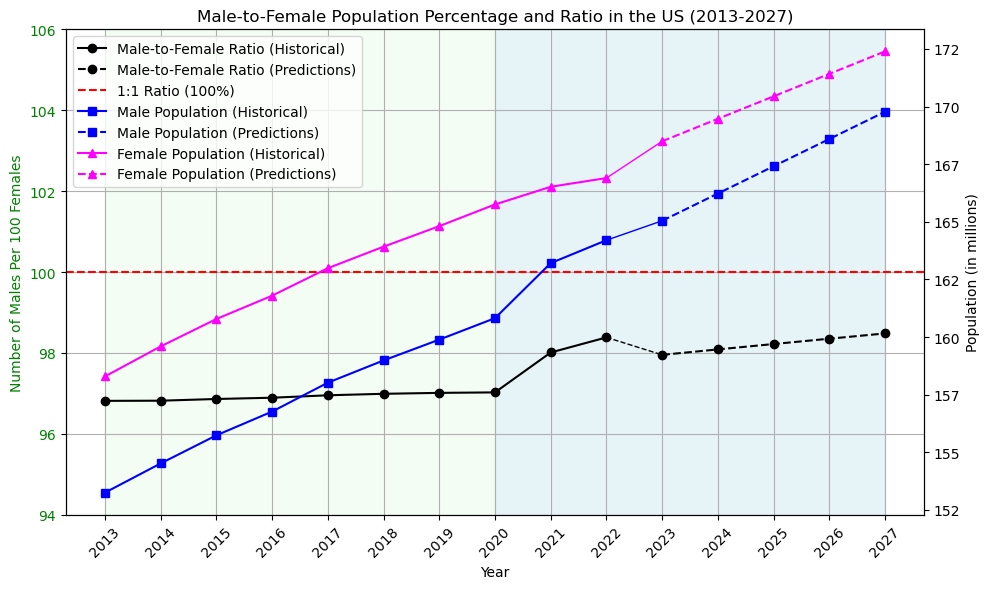

In [10]:
# Combine historical years and future years for both male and female populations
combined_years = years + future_years

# Combine historical male populations
historical_male_populations = male_populations
# Future male populations
future_male_populations = predicted_male_pop.tolist()
# Combine historical and predicted male populations
combined_male_populations = historical_male_populations + future_male_populations

# Combine historical female populations
historical_female_populations = female_populations
# Future female populations
future_female_populations = predicted_female_pop.tolist()
# Combine historical and predicted female populations
combined_female_populations = historical_female_populations + future_female_populations

# Combine historical male-to-female percentages and predicted percentages
combined_percentages = male_female_percentages + predicted_percentages

# Plot the data using matplotlib
fig, ax1 = plt.subplots(figsize=(10, 6))  # Create a figure and axis for the plot

# Plot the Male-to-Female Percentage for Historical Data
ax1.plot(years, male_female_percentages, 
         marker='o', linestyle='-', color='black', label='Male-to-Female Ratio (Historical)')

# Plot the Male-to-Female Percentage for Future Data
ax1.plot(future_years, predicted_percentages, 
         marker='o', linestyle='--', color='black', label='Male-to-Female Ratio (Predictions)')

# Connect the last historical point to the first future point for the male-to-female ratio
ax1.plot([years[-1], future_years[0]], 
         [male_female_percentages[-1], predicted_percentages[0]], 
         color='black', linestyle='--', linewidth=1)

# Find the midpoint of the graph based on the combined years
mid_year = (combined_years[0] + combined_years[-1]) / 2

# Create a light green background for the first half of the graph
ax1.axvspan(combined_years[0], mid_year, color='lightgreen', alpha=0.1, zorder=0)

# Create a light blue background for the second half of the graph
ax1.axvspan(mid_year, combined_years[-1], color='lightblue', alpha=0.3, zorder=0)

# Set the x-axis label
ax1.set_xlabel("Year")  
# Set the y-axis label for the first y-axis (left)
ax1.set_ylabel("Number of Males Per 100 Females", color='green')  
ax1.tick_params(axis='y', labelcolor='g')  # Set y-axis tick parameters
ax1.grid(True)  # Enable grid on the plot
# Set x-axis ticks to include both historical and future years
ax1.set_xticks(combined_years)  
# Rotate x-axis labels for better visibility
ax1.set_xticklabels(combined_years, rotation=45)  

# Set the y-axis ticks from 94 to 106, with 2% increments
ax1.set_yticks(range(94, 107, 2))  
# Set the y-axis limits
ax1.set_ylim([94, 106])  

# Add a horizontal line at y=100 (1:1 ratio in percentage terms)
ax1.axhline(y=100, color='r', linestyle='--', label='1:1 Ratio (100%)')  

# Create a second y-axis to show male and female population counts
ax2 = ax1.twinx()  # Create a twin y-axis sharing the same x-axis

# Plot historical male populations as a solid line
ax2.plot(years, historical_male_populations, 
         marker='s', linestyle='-', color='blue', label='Male Population (Historical)')

# Plot future male populations as a dashed line
ax2.plot(future_years, future_male_populations, 
         marker='s', linestyle='--', color='blue', label='Male Population (Predictions)')

# Connect the last historical point to the first future point for males
ax2.plot([years[-1], future_years[0]], 
         [historical_male_populations[-1], future_male_populations[0]], 
         color='blue', linestyle='-', linewidth=1)

# Plot historical female populations as a solid line
ax2.plot(years, historical_female_populations, 
         marker='^', linestyle='-', color='magenta', label='Female Population (Historical)')

# Plot future female populations as a dashed line
ax2.plot(future_years, future_female_populations, 
         marker='^', linestyle='--', color='magenta', label='Female Population (Predictions)')

# Connect the last historical point to the first future point for females
ax2.plot([years[-1], future_years[0]], 
         [historical_female_populations[-1], future_female_populations[0]], 
         color='magenta', linestyle='-', linewidth=1)

# Set the y-axis label for the second axis (right)
ax2.set_ylabel("Population (in millions)", color='black')  
ax2.tick_params(axis='y', labelcolor='black')  # Set y-axis tick parameters for the right side

# Formatting the y-axis on the right to show whole numbers (in millions)
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000000)}'))  # Format y-axis ticks

# Combine legends from both axes into one
lines, labels = ax1.get_legend_handles_labels()  # Get the first axis legend
lines2, labels2 = ax2.get_legend_handles_labels()  # Get the second axis legend
ax1.legend(lines + lines2, labels + labels2, loc='upper left')  # Combine legends

# Title and layout adjustments
plt.title("Male-to-Female Population Percentage and Ratio in the US (2013-2027)")  # Set plot title
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding

# Display the plot
plt.show()  # Show the final plot
